## Strange Network Development

In [57]:
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np
from rasterio.plot import show
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Assign your specific GPU so we don't overlap

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"; # Would I change this to 3?

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [4]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

Ingest the landsat imagery stacked into yearly seasonal tiles

In [5]:
tiles = {}
landsat_datasets = {}
# Could change to test one season at a time
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets
    

In [6]:
tile_size = 1
tile_list = ['028012', '029011', '028011']
class_count = 6
epochs = 200
batch_size = 25

# The next two cells are for making pixels and prepping them for training (balancing)
### This is unnecessary to run because I already saved them to text files so now you load them

In [7]:
# px = rnn_pixels.make_pixels(tile_size, tile_list) 
# px_to_use = px[:1000]
# pixels = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, px_to_use, tile_size)

In [8]:
# w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
# w_generator = w_tile_gen.tile_generator(pixels, batch_size=1, flatten=True, canopy=False)

In [9]:
# # gets balanced pixels locations 
# w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
# w_generator = w_tile_gen.tile_generator(pixels, batch_size=1, flatten=True, canopy=False)
# total_labels = list()
# count = 0
# #buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
# buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}

# while count < len(pixels):
#         image_b, label_b = next(w_generator)
#         print(image_b.shape)
#         print(label_b.shape)
#         print(image_b)
#         print(label_b)
#         label_b = np.argmax(label_b)
#         buckets[label_b].append(pixels[count]) # appends pixels to dictionary
#         total_labels.append(label_b)
#         count+=1
#         break
# total_labels = np.asarray(total_labels)
# total_labels = total_labels.reshape(len(total_labels)*tile_size*tile_size)
# #weights_list = class_weight.compute_class_weight('balanced', np.unique(total_labels), total_labels)
# count = 0 
# for z, j in buckets.items():
#     print(len(j))
#     count += len(j)
# print(count) 
# use_px = []
# use_px+=buckets[0][:3000]
# use_px+=(buckets[1][:3000])
# use_px+=(buckets[2][:3000])
# use_px+=(buckets[3][:3000])
# use_px+=(buckets[4][:3000])
# use_px+=(buckets[5][:3000])
# random.shuffle(use_px)
# train_px, val_px, test_px = rnn_pixels.train_val_test_split(use_px, 0.7, 0.7)
# print('first training pixel',train_px)

# Load pixels

In [10]:
train_px, val_px, test_px = util.read_txt(['train_px.txt', 'val_px.txt', 'test_px.txt'])
train_px = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, train_px, tile_size)
val_px =  rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, val_px, tile_size)
test_px =  rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, test_px, tile_size)
pixel_1 = train_px[0]


tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
train_generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy= False)
test_generator = tile_gen.tile_generator(test_px, batch_size =1, flatten = True, canopy = False)

tiles_train = []
landcover_train = []

tiles_test = []
landcover_test = []

for x in range(0,1000):
    l = next(train_generator)
    tiles_train.append(np.ndarray.flatten(l[0][0]))
    landcover_train.append(np.ndarray.flatten(l[1][0]))
    
for x in range(0,1000):
    l = next(test_generator)
    tiles_test.append(np.ndarray.flatten(l[0][0]))
    landcover_test.append(np.ndarray.flatten(l[1][0]))

# print('first',x[0])
# print('second',x[1])
# for x in generator:
#     tiles.append(x[0])
#     landcover.append(x[1])
#     print(1)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
1000
2000
3000
1000
2000


In [43]:
#SVM
clf = svm.SVC()
clf.fit(tiles_train,np.argmax(landcover_train, axis=1))
pred_clf = clf.predict(tiles_test)
print('Classification Report')
print(classification_report(np.argmax(landcover_test,axis = 1), pred_clf))
print('Confusion Matrix')
print(confusion_matrix(np.argmax(landcover_test,axis = 1), pred_clf))


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       180
           1       0.72      0.75      0.74       183
           2       0.84      0.91      0.88       184
           3       0.67      0.76      0.71       176
           4       0.68      0.48      0.56       100
           5       0.80      0.75      0.77       177

    accuracy                           0.79      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.79      0.79      0.79      1000

Confusion Matrix
[[173   0   0   0   2   5]
 [  0 137   2  23  18   3]
 [  0   3 168   8   0   5]
 [  0  17  14 134   1  10]
 [  4  27   3   9  48   9]
 [  1   5  12  25   2 132]]


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [79]:
# RFC Neighbor Testing
n_range = range(1,1000,10)
scores_n = []
for n in n_range:
    rfc_test = RandomForestClassifier(n_estimators = n)
    rfc_test.fit(tiles_train, np.argmax(landcover_train,axis = 1))
    pred_rfc_test = rfc_test.predict(tiles_test)
    scores_n.append(accuracy_score(np.argmax(landcover_test,axis = 1), pred_rfc_test))

Text(0.5, 1.0, '0 to 1000')

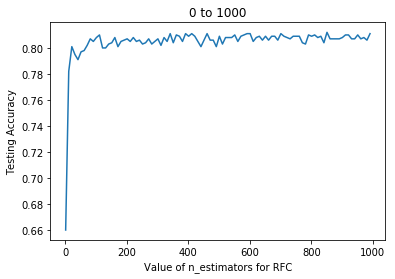

In [80]:
# RFC Testing Plot
%matplotlib inline 
plt.figure(1);
plt.plot(n_range,scores_n)
plt.xlabel('Value of n_estimators for RFC')
plt.ylabel('Testing Accuracy')
plt.title('0 to 1000')

In [45]:
#RFC

rfc = RandomForestClassifier(n_estimators = 350)
rfc.fit(tiles_train,np.argmax(landcover_train, axis=1))
pred_rfc = rfc.predict(tiles_test)
print('Classification Report')
print(classification_report(np.argmax(landcover_test,axis = 1), pred_rfc))
print('Confusion Matrix')
print(confusion_matrix(np.argmax(landcover_test,axis = 1), pred_rfc))

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       180
           1       0.76      0.77      0.77       183
           2       0.87      0.91      0.89       184
           3       0.70      0.78      0.74       176
           4       0.65      0.55      0.59       100
           5       0.81      0.76      0.78       177

    accuracy                           0.81      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.81      0.81      0.81      1000

Confusion Matrix
[[174   0   0   0   2   4]
 [  0 141   2  15  21   4]
 [  0   2 167   8   1   6]
 [  0  18   9 138   3   8]
 [  3  20   2  11  55   9]
 [  0   4  11  25   3 134]]


In [66]:
# KNN Neighbor Testing
k_range = range(1,100)
scores = []
for k in k_range:
    knn_test = KNeighborsClassifier(n_neighbors = k)
    knn_test.fit(tiles_train,np.argmax(landcover_train, axis=1))
    pred_knn_test = knn_test.predict(tiles_test)
    scores.append(accuracy_score(np.argmax(landcover_test,axis =1),pred_knn_test))
    

Text(0.5, 1.0, '15 to 35')

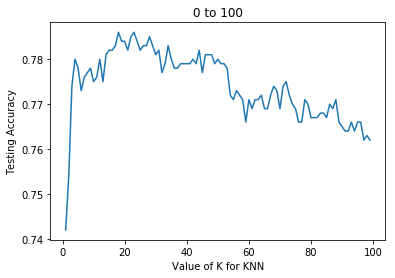

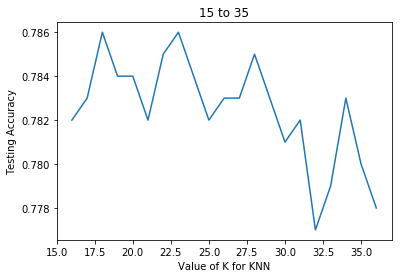

In [74]:
# KNN Testing Plot
%matplotlib inline 
plt.figure(1);
plt.plot(k_range,scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.title('0 to 100')


plt.figure(2);
plt.plot(k_range[15:36],scores[15:36])
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.title('15 to 35')

In [76]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 23)
knn.fit(tiles_train,np.argmax(landcover_train, axis=1))
pred_knn = knn.predict(tiles_test)
print('Classification Report')
print(classification_report(np.argmax(landcover_test,axis = 1), pred_knn))
print('Confusion Matrix')
print(confusion_matrix(np.argmax(landcover_test,axis = 1), pred_knn))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       180
           1       0.67      0.82      0.74       183
           2       0.84      0.92      0.88       184
           3       0.71      0.68      0.69       176
           4       0.68      0.38      0.49       100
           5       0.81      0.75      0.78       177

    accuracy                           0.79      1000
   macro avg       0.78      0.75      0.76      1000
weighted avg       0.78      0.79      0.78      1000

Confusion Matrix
[[177   0   0   0   0   3]
 [  0 150   3  10  16   4]
 [  0   3 170   7   0   4]
 [  0  33  14 119   2   8]
 [  8  33   2   7  38  12]
 [  2   6  13  24   0 132]]


In [55]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(tiles_train,np.argmax(landcover_train, axis=1))
pred_logreg = logreg.predict(tiles_test)
print('Classification Report')
print(classification_report(np.argmax(landcover_test,axis = 1), pred_logreg))
print('Confusion Matrix')
print(confusion_matrix(np.argmax(landcover_test,axis = 1), pred_logreg))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       180
           1       0.75      0.73      0.74       183
           2       0.85      0.91      0.88       184
           3       0.69      0.74      0.72       176
           4       0.70      0.54      0.61       100
           5       0.80      0.79      0.79       177

    accuracy                           0.80      1000
   macro avg       0.79      0.78      0.78      1000
weighted avg       0.80      0.80      0.80      1000

Confusion Matrix
[[172   0   0   0   1   7]
 [  0 134   3  25  17   4]
 [  0   3 168   9   0   4]
 [  0  22  13 131   3   7]
 [  7  15   3   7  54  14]
 [  2   4  11  18   2 140]]


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Create the RNN

In [12]:
# def strangeBlock_v4(input_block, nb_layers, filters):
#     x_list = [input_block]
#     c_temp = input_block
#     for i in range(nb_layers):
#         c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
#         x_list.append(c_l)
#         merge = Concatenate()(x_list)
#         c_temp = merge
#     return c_temp
    

In [13]:
# def make_MLT_dense(in_shape, num_classes):
#     input_tensor = Input(shape = in_shape)
#     block = strangeBlock_v4(input_tensor, 5, 12)
#     block_2 = strangeBlock_v4(block, 3, 20)
#     landcover = LSTM(num_classes,activation='softmax', return_sequences=False, name='landcover') (block_2)
#     canopy = LSTM(1, return_sequences=False, name='canopy') (block_2)
#     model = Model(inputs=input_tensor, outputs=[landcover, canopy])
#     return model

#### Train the Model

In [14]:
# filepath = 'mlt_dense_model_pcg.hdf5'#your filepath here
# checkpoint = ModelCheckpoint(filepath, monitor='val_landcover_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
# tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [15]:
# model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy', 'canopy':'mae'}, metrics={'landcover':['accuracy'], 'canopy':['mae']}, loss_weights={"landcover":1, "canopy":1})

In [16]:
# model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
#                     steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
#                    validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
# #                   validation_steps=len(val_px) // batch_size, callbacks=callbacks_list)# class_weight=weights_list)# callbacks=callbacks_list) #class_weight=weights, callbacks=callbacks_list) 

In [17]:
# model.save('mlt_dense_pcg.h5')

### Inspect Training Data

In [18]:
# predictions = model.predict_generator(generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True), steps=len(train_px) // 1, verbose=1)
# eval_generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True)

In [19]:
# lc_predictions_train = np.asarray(predictions[0])
# canopy_pred_train = np.asarray(predictions[1])
# lc_predictions_train = np.argmax(lc_predictions_train,axis=-1)

In [20]:
# lc_lab_train = np.empty(lc_predictions_train.shape)
# canopy_true_train = np.empty(canopy_pred_train.shape)
# count = 0
# while count < len(lc_predictions_train):
#         image_b, label_b = next(eval_generator)
#         #label_b = np.argmax(label_b, axis=-1)
#         label_lc = np.argmax(label_b['landcover'], axis=-1)
#         canopy_true_train[count] = label_b['canopy']
#         lc_lab_train[count] = label_lc
#         count += 1
# label_index = lc_lab_train.reshape(len(train_px)*tile_size*tile_size)
# pred_index = lc_predictions_train.reshape(len(train_px)*tile_size*tile_size)

In [21]:
# plt.hist(canopy_true_train, alpha=0.75), plt.hist(canopy_pred_train, alpha=0.5)

In [22]:
# from sklearn.metrics import r2_score
# r2_score(canopy_true_train, canopy_pred_train)

In [23]:
# from scipy.stats import gaussian_kde

# x = (canopy_pred_train * 100).flatten()
# y = (canopy_true_train * 100).flatten()

# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)

# idx = z.argsort()

# fig,ax = plt.subplots()
# ax.scatter(x,y,c=z,s=50,edgecolor='')
# ax.set_xlabel("Predictions")
# ax.set_ylabel("Annotations")
# ax.set_title("Canopy Cover Predictions")
# plt.show()

# Evaluate model

In [24]:
# # Hands the generator to the keras model -> says to make predictions
# predictions = model.predict_generator(generator = tile_gen.tile_generator(test_px, batch_size=1, flatten=True, canopy=True), steps=len(test_px) // 1, verbose=1)
# eval_generator = tile_gen.tile_generator(test_px, batch_size=1, flatten=True, canopy=True)

In [25]:
# lc_predictions = np.asarray(predictions[0])
# canopy_pred = np.asarray(predictions[1])
# lc_predictions = np.argmax(lc_predictions,axis=-1)

In [26]:
# lc_lab = np.empty(lc_predictions.shape)
# canopy_true = np.empty(canopy_pred.shape)
# count = 0
# while count < len(lc_predictions):
#         image_b, label_b = next(eval_generator)
#         #label_b = np.argmax(label_b, axis=-1)
#         label_lc = np.argmax(label_b['landcover'], axis=-1)
#         canopy_true[count] = label_b['canopy']
#         lc_lab[count] = label_lc
#         count += 1
# label_index = lc_lab.reshape(len(test_px)*tile_size*tile_size)
# pred_index = lc_predictions.reshape(len(test_px)*tile_size*tile_size)

In [27]:
# np.set_printoptions(precision=2)
# # Plot non-normalized confusion matrix
# util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
#                       class_dict=util.indexed_dictionary)
# # Plot normalized confusion matrix
# util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
#                       class_dict=util.indexed_dictionary,
#                       normalize=True)
# count = 0
# for i in range(len(label_index)):
#     if(label_index[i] == pred_index[i]):
#         count+=1
# print("Accuracy is {}".format(count/len(label_index)))

# plt.savefig("confusion_matrix.png", dpi=1000)

In [28]:
# total = 0
# tot = 0
# for count in range(len(canopy_pred)):
#     if canopy_true[count] != 0 and canopy_pred[count] !=0:
#         if canopy_pred[count] < 0:
#             canopy_pred[count] = 0
#         total+= np.absolute(canopy_pred[count] - canopy_true[count])
#         tot+=1
# print(total/tot)

In [29]:
# label_index.shape

In [30]:
# label_index, 

In [31]:
# import pandas as pd
# pred_df = pd.DataFrame({'lc_pred': pred_index,
#                         'lc_true': label_index,
#                         'canopy_pred': canopy_pred.flatten(),
#                         'canopy_true': canopy_true.flatten()})
# pred_df[pred_df["lc_true"] == 0].head()

In [32]:
# sns.jointplot(pred_df['canopy_pred'], y=pred_df['canopy_true'], kind='scatter')

In [33]:
# g = sns.jointplot(x=pred_df['canopy_pred'], y=pred_df['canopy_true'], kind='reg', scatter=False)

# g.ax_joint.scatter(x=pred_df['canopy_pred'], y=pred_df['canopy_true'], c=pred_df['lc_true'])

In [34]:
# plt.hist(canopy_pred)

In [35]:
# plt.hist(canopy_true)

In [36]:
# from scipy.stats import gaussian_kde

# x = (canopy_pred * 100).flatten()
# y = (canopy_true * 100).flatten()


# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)

# idx = z.argsort()

# fig,ax = plt.subplots()
# ax.scatter(x,y,c=z,s=50,edgecolor='', alpha=0.7)
# ax.set_xlabel("Predictions")
# ax.set_ylabel("Annotations")
# ax.set_title("Canopy Cover Predictions")
# plt.savefig("canopy_regression.png", dpi=1000)

In [37]:
# plt.scatter(canopy_pred, canopy_true)
# plt.xlabel("Canopy Fraction Predictions")
# plt.ylabel("Canopy Fraction Annotations")
# plt.savefig("canopy_regression.png", dpi=1000)

In [38]:
# from sklearn.metrics import r2_score
# r2_score(canopy_true, canopy_pred)

In [39]:
# # library & dataset
# import seaborn as sns
# df = sns.load_dataset('iris')
 

# sns.jointplot(y=(canopy_true*100).flatten(), x=(canopy_pred*100).flatten(), kind='scatter')
# sns.jointplot(pred_df['canopy_pred'], y=pred_df['canopy_true'], kind='scatter')

# sns.jointplot(x=(canopy_true*100).flatten(), y=(canopy_pred*100).flatten(), kind='hex')
# sns.jointplot(x=(canopy_true*100).flatten(), y=(canopy_pred*100).flatten(), kind='kde')
